# **Feature Selection**

In [ ]:

# Load dataset

df = pd.read_csv("processed_Normalized.csv")
print("Dataset loaded .. shape:", df.shape)

TARGET = "stress_level"

device_cols = ['phone_usage_hours','tablet_usage_hours',
               'laptop_usage_hours','tv_usage_hours']
device_cols = [c for c in device_cols if c in df.columns]

if device_cols:
    df['total_screen_hours'] = df[device_cols].sum(axis=1)
else:
    df['total_screen_hours'] = df['daily_screen_time_hours']

if 'sleep_duration_hours' in df.columns:
    df['screen_per_sleep'] = df['total_screen_hours'] / df['sleep_duration_hours'].replace(0,np.nan)
    df['sleep_deficit'] = 8 - df['sleep_duration_hours']
    df['short_sleep'] = (df['sleep_duration_hours'] < 7).astype(int)

if 'social_media_hours' in df.columns:
    df['digital_ratio'] = df['social_media_hours'] / df['total_screen_hours'].replace(0,np.nan)

if {'work_related_hours','entertainment_hours'}.issubset(df.columns):
    df['work_leisure_ratio'] = df['work_related_hours'] / df['entertainment_hours'].replace(0,np.nan)

if {'caffeine_intake_mg_per_day','sleep_duration_hours'}.issubset(df.columns):
    df['caffeine_per_sleep_hour'] = df['caffeine_intake_mg_per_day'] / df['sleep_duration_hours'].replace(0,np.nan)

if 'total_screen_hours' in df.columns:
    df['high_screen'] = (df['total_screen_hours'] > df['total_screen_hours'].median()).astype(int)

new_features = [c for c in df.columns if c not in pd.read_csv("processed_Normalized.csv").columns]
print(" New Features Created:", new_features)



Dataset loaded .. shape: (2000, 26)
 New Features Created: ['total_screen_hours', 'screen_per_sleep', 'sleep_deficit', 'short_sleep', 'digital_ratio', 'work_leisure_ratio', 'caffeine_per_sleep_hour', 'high_screen']


Target variable 'stress_level' discretized into categories for Mutual Information calculation.


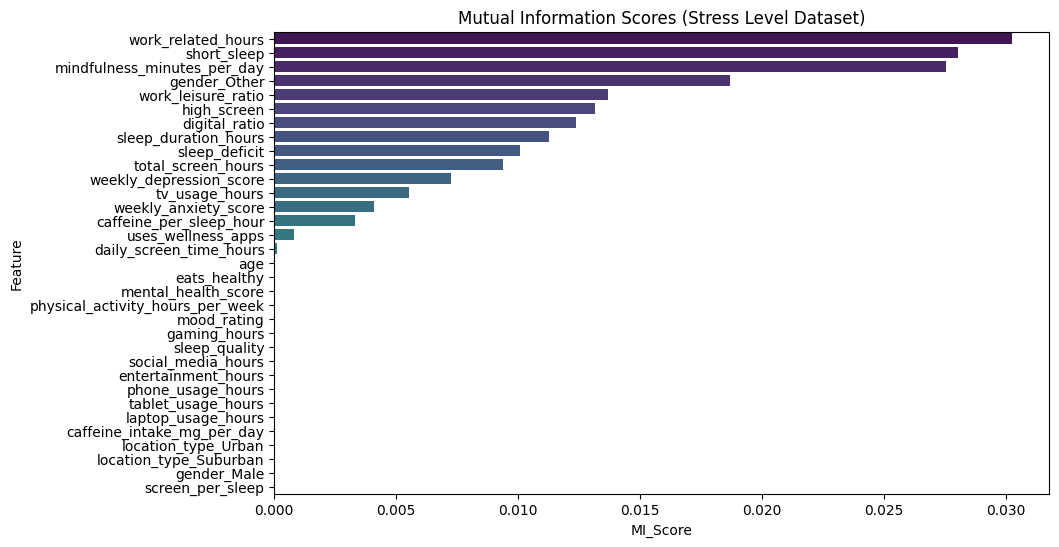

Final Selected Features (Top 10 by MI): ['work_related_hours', 'short_sleep', 'mindfulness_minutes_per_day', 'gender_Other', 'work_leisure_ratio', 'high_screen', 'digital_ratio', 'sleep_duration_hours', 'sleep_deficit', 'total_screen_hours']


In [ ]:


X = df.drop(columns=[TARGET], errors="ignore").select_dtypes(include='number')
y = df[TARGET] if TARGET in df.columns else None

# Discretize the target variable if it exists
if y is not None:
    try:
        y_discrete = pd.cut(y, bins=10, labels=False, duplicates='drop')
        print(f"Target variable '{TARGET}' discretized into categories for Mutual Information calculation.")

        # Calculate Mutual Information scores
        mi_scores = mutual_info_classif(X, y_discrete, discrete_features="auto", random_state=42)
        mi_df = pd.DataFrame({"Feature": X.columns, "MI_Score": mi_scores})
        mi_df = mi_df.sort_values(by="MI_Score", ascending=False)

        plt.figure(figsize=(10,6))
        sns.barplot(x="MI_Score", y="Feature", data=mi_df, hue="Feature",dodge=False, palette="viridis",legend=False)
        plt.title("Mutual Information Scores (Stress Level Dataset)")
        plt.show()

        # Select top features
        selected_features = mi_df["Feature"].tolist()[:10]
        print("Final Selected Features (Top 10 by MI):", selected_features)
        df.to_csv("feature_selection", index=False)

    except Exception as e:
        print(f"An error occurred during Mutual Information calculation: {e}")
        print("Skipping Mutual Information calculation and plotting.")
else:
    print(f"Target variable '{TARGET}' not found or could not be processed. Skipping Mutual Information calculation and plotting.")